<div class="jumbotron jumbotron-fluid">
  <div class="container">
    <h1 class="display-4">Invasive Species Prediction - D. Villosus</h1>
    <p class="lead">A short notebook introducing techniques for GIS Data analysis on the potential migration of the Killer Shrimp into the Baltic Sea region.</p>
  </div>
</div>

In [ ]:
# Download data folder
!curl -L -o data.zip https://www.dropbox.com/sh/4qsj9yvgd88nlx1/data.zip?dl=1

<div class="alert alert-info" role="alert">
    
### NOTE: Data folder should be at the same level as the notebooks provided. 
    
</div>


![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5eEvt95JEQ0TwjMr_Wk0Aw4E0QD1XkxgPyjWaMgClG1o8-btIcQ&s)

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import IFrame

In [3]:
# Imports
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import swifter

<div class="alert alert-success" role="alert">

### So, we have found some data:

1. Port locations in Europe (EMODNET Human Activities)
2. Ocean surface temperatures and salinity for Baltic Sea (SMHI) and North Sea regions (SeaDataNet)
3. Presence data of D. Villosus from observations ranging from 1928-2019 (from GBIF)
    
</div>

<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 0%;" aria-valuenow="0" aria-valuemin="0" aria-valuemax="100">0%</div>
</div>

<div class="alert alert-info" role="alert">
    
### Next question: How do we visualize this?
    
</div>

<div class="alert alert-success" role="alert">

<p><img src="https://d1a3f4spazzrp4.cloudfront.net/kepler.gl/website/icons/kepler.gl-logo.png" align="left" alt="Kepler GL" width="200"></p>
<p align="left">Kepler.gl is a powerful open source geospatial analysis tool for large-scale data sets.</p>
    
</div>

![](https://d1a3f4spazzrp4.cloudfront.net/kepler.gl/website/showcase/lines-s.png)

In [4]:
# Load all the data we have

## Presence
pres_df = pd.read_csv('./Data/Presence/records.csv',
                      delimiter='\t')[['decimalLatitude', 'decimalLongitude', 
                                       'eventDate']].dropna().set_index('eventDate')
pres_df = pres_df.sort_index().reset_index()

## Port data
baltic_ports = pd.read_csv('./Data/baltic_ports.txt', sep=' ', index_col=0)

## River data
hydro = gpd.GeoDataFrame.from_file('./Data/Europe_Hydrography/Europe_Hydrography.shp').to_json()

<div class="alert alert-info" role="alert">

### Simple Kepler GL layer
    
</div>

In [5]:
from keplergl import KeplerGl
map_1 = KeplerGl(width = 800, height=600)
map_1.add_data(pres_df, name='pres')
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'pres': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

<div class="alert alert-info" role="alert">

### Adding layers on top
    
</div>

In [6]:
from keplergl import KeplerGl
map_1 = KeplerGl(width = 800, height=600)
map_1.add_data(pres_df, name='presence')
map_1.add_data(baltic_ports, name='absence')
map_1.add_data(hydro, name='rivers')
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'presence': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

<div class="alert alert-success" role="alert">

### So far we have only visualisation, now some modelling...
</div>
<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 25%;" aria-valuenow="25" aria-valuemin="0" aria-valuemax="100">25%</div>
</div>

<div class="alert alert-info" role="alert">

## Question: How do temperature and salinity affect the presence of killer shrimp?
    
</div>

<div class="alert alert-warning" role="alert">

#### Some assumptions:
#### 1. The ports in the baltic are labelled "absence" locations
#### 2. We assume that the nearest measurement is appropriate for a given location (i.e. no interpolation)
    
</div>




In [7]:
all_ports = [[feature['geometry']['coordinates'][1], feature['geometry']['coordinates'][0]] for \
             feature in json.load(open('./Data/ports.json'))['features']]

<div class="alert alert-info" role="alert">

### Subtask: Matching each port to its nearest weather observation
    
</div>

<div>
<img src="https://www.geosci-model-dev.net/12/1189/2019/gmd-12-1189-2019-f01-web.png" width="500"/>
</div>

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
def get_nearest_station(array, w_stations):
    knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=1, metric='euclidean')
    X = np.array([[i[0], i[1]] for i in w_stations])
    y = np.arange(len(w_stations))
    knn.fit(X, y)
    ids = knn.predict(array)
    return ids

In [10]:
nsoc_data = pd.read_csv('./Data/north_sea_temp_salinity_historical.txt', sep=' ')
nsoc_data['coordinates'] = list(zip(nsoc_data.lat, nsoc_data.lon))
nsoc_data = nsoc_data[(nsoc_data.temp > -100) & (nsoc_data.salinity > -100)]

##### Dont run

In [23]:
pres_df['coordinates'] = list(zip(pres_df.decimalLatitude, pres_df.decimalLongitude))
pres_df['reference_port'] = pres_df.swifter.apply(lambda x: \
                                          all_ports[get_nearest_station(
                                          np.array(x['coordinates']).reshape(1, -1), all_ports)[0]], 1)
pres_df[['ref_port_lat', 'ref_port_lon']] = pd.DataFrame(pres_df['reference_port'].tolist(), index=pres_df.index)    

pres_df[['temp', 'salinity']] = pres_df.swifter.apply(lambda x: \
                                nsoc_data[nsoc_data.date.str[:7] == x['eventDate'][:7]].iloc[get_nearest_station(
                                np.array(
                                x['reference_port']).reshape(1, -1),
                                nsoc_data[nsoc_data.date.str[:7] == x['eventDate'][:7]]['coordinates'])[0]] \
                                [['temp', 'salinity']] 
                                if len(nsoc_data[nsoc_data.date.str[:7] == x['eventDate'][:7]]) > 0 else None, 1)

In [24]:
# export for fast import
#pres_df.to_csv('pres_df.csv')

In [11]:
pres_df = pd.read_csv('./Data/pres_df.csv')

In [12]:
np_ports = pd.read_csv('./Data/baltic_ports.txt', sep=' ', index_col=0)
baltic_temp = pd.read_csv(
                './Data/baltic_temperatures_latest.txt', sep='\t', encoding='cp1252')[['Provtagningsdatum', 
                                                                                'Provets latitud (DD)',
                                                                                'Provets longitud (DD)',
                                                                                'Mätvärde']].dropna()
baltic_sal = pd.read_csv(
                './Data/baltic_salinity_latest.txt', sep='\t', encoding='cp1252')[['Provtagningsdatum',
                                                                            'Provets latitud (DD)',
                                                                            'Provets longitud (DD)',
                                                                            'Mätvärde']].dropna()

<div class="alert alert-warning" role="alert">

### For our purposes, we focus on the winter months of December - February
    
</div>


In [13]:
baltic_temp = baltic_temp[baltic_temp.Provtagningsdatum.str[5:7].isin(['12', '01', '02'])]
baltic_sal = baltic_sal[baltic_sal.Provtagningsdatum.str[5:7].isin(['12', '01', '02'])]

In [14]:
baltic_temp.columns = ['date', 'lat', 'lon', 'temperature']
baltic_sal.columns = ['date', 'lat', 'lon', 'salinity']

In [15]:
baltic_temp[['lat', 'lon', 'temperature']] = baltic_temp[['lat', 'lon', 'temperature']].apply(
                                             lambda x: x.str.replace(',', '.')).astype(float)
baltic_sal[['lat', 'lon', 'salinity']] = baltic_sal[['lat', 'lon', 'salinity']].apply(
                                            lambda x: x.str.replace(',', '.')).astype(float)

In [16]:
baltic_temp = baltic_temp.groupby(by=['lat','lon']).mean().reset_index()
baltic_sal = baltic_sal.groupby(by=['lat','lon']).mean().reset_index()

In [17]:
np_ports['temp'] = [baltic_temp.iloc[i]['temperature'] for 
                    i in get_nearest_station([i[0] for i in zip(
                    np_ports[['lat', 'lon']].values)], 
                    [i[0] for i in zip(baltic_temp[['lat', 'lon']].values)])]
np_ports['salinity'] = [baltic_sal.iloc[i]['salinity'] for i in get_nearest_station([i[0] for i in zip(
                    np_ports[['lat', 'lon']].values)], 
                    [i[0] for i in zip(baltic_sal[['lat', 'lon']].values)])]

In [18]:
p_plot = pres_df[['eventDate', 'ref_port_lat', 'ref_port_lon', 'temp', 'salinity']].iloc[1:]
p_plot.columns = ['date', 'lat', 'lon', 'temp', 'salinity']
p_plot = p_plot[p_plot.date.str[5:7].isin(['10', '11', '12', '01', '02'])]
p_plot = p_plot.groupby(by=['lat','lon']).mean().reset_index()
p_plot['obs'] = 1

In [19]:
np_ports['obs'] = 0

In [20]:
plot_df = pd.concat([p_plot[['lat', 'lon', 'temp', 'salinity', 'obs']], 
                     np_ports[['lat', 'lon', 'temp', 'salinity', 'obs']]])

In [21]:
plot_df = plot_df.dropna()

<div class="alert alert-info" role="alert">

    
### Sanity check 
    
We can now investigate whether our temperature and salinity data makes sense in the context of our port locations. 
Our processed dataframe can now be passed as a single layer to Kepler GL.
    
In the Point layer, we can now colour each point by the temperature value. 
    
Another way to look at this data is to choose "Hexbin" under the Basic section, and then customise the height based on the temperature value. This is more useful when many features are available. 
    
</div>

<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 50%;" aria-valuenow="50" aria-valuemin="0" aria-valuemax="100">50%</div>
</div>

In [22]:
map_2 = KeplerGl(width = 800, height=600)
map_2.add_data(plot_df, name='o')
map_2

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'o': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, …

<div class="alert alert-info" role="alert">

### Tree Model for Classification
    
</div>

In [23]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
X = plot_df[['lat', 'lon', 'temp', 'salinity']]
y = plot_df['obs']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [26]:
clf = tree.DecisionTreeClassifier(max_depth=2)

In [27]:
clf = clf.fit(X_train[['temp', 'salinity']], y_train)

In [28]:
accuracy_score(y_test, clf.predict(X_test[['temp', 'salinity']]))

0.9565217391304348

[Text(502.20000000000005, 453.0, 'X[0] <= 8.392\ngini = 0.383\nsamples = 89\nvalue = [66, 23]'),
 Text(334.8, 271.8, 'X[0] <= 3.64\ngini = 0.029\nsamples = 67\nvalue = [66, 1]'),
 Text(167.4, 90.59999999999997, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(502.20000000000005, 90.59999999999997, 'gini = 0.0\nsamples = 63\nvalue = [63, 0]'),
 Text(669.6, 271.8, 'gini = 0.0\nsamples = 22\nvalue = [0, 22]')]

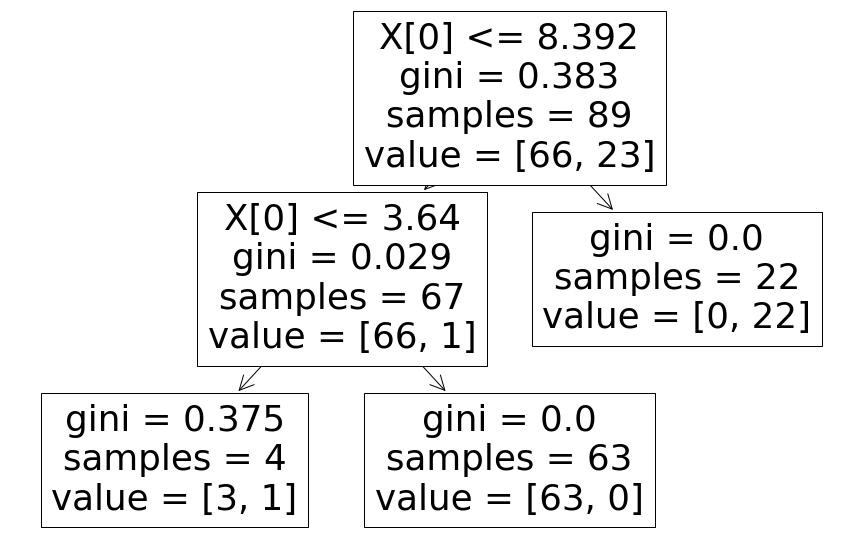

In [29]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf.fit(X_train[['temp', 'salinity']], y_train)) 

<div class="alert alert-info" role="alert">

    
### Sanity check 
    
From Wikipedia we can glean the climatic conditions under which the Killer Shrimp can survive and we can cross-reference this with our model results.

</div>

<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 75%;" aria-valuenow="75" aria-valuemin="0" aria-valuemax="100">75%</div>
</div>

In [127]:
IFrame(src='https://en.wikipedia.org/wiki/Dikerogammarus_villosus', width=1000, height=400)

<div class="alert alert-info" role="alert">

    
### How does the model decide between the two classes?
    
</div>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c31c1a048>,
      dtype=object)

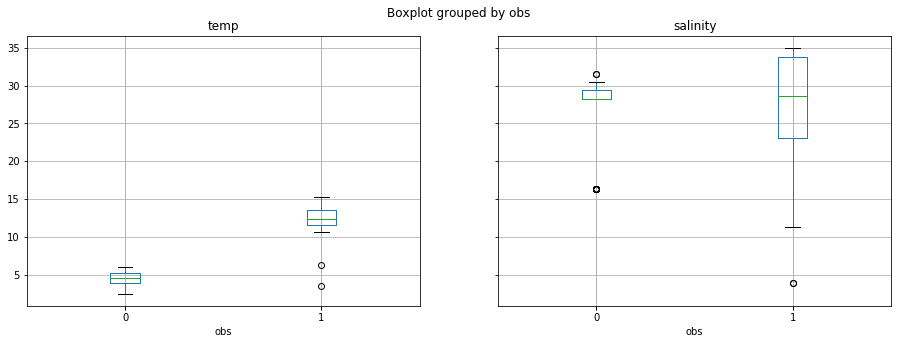

In [32]:
box_df = plot_df.iloc[:,2:]
box_df['obs'] = box_df['obs'].astype(str)
box_df['temp'] = box_df['temp'].astype(float)
box_df['salinity'] = box_df['salinity'].astype(float)
box_df.boxplot(column=['temp', 'salinity'], by='obs', figsize=(15,5))

<div class="alert alert-info" role="alert">


### Now that we have a pipeline we can add many other features:

- Substrates (sand or rocks)
- Altitude
- ...etc
    
</div>

<div class="alert alert-info" role="alert">

    
### What about rasters?
    
</div>

<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 100%;" aria-valuenow="100" aria-valuemin="0" aria-valuemax="100">100%</div>
</div>

![](https://www.oceanecology.ca/species_model_data.jpg)

<div class="alert alert-info" role="alert">


### Modelling Species Distribution


</div>



In [33]:
from pyimpute import load_training_vector, load_targets, impute, evaluate_clf
from sklearn.ensemble import RandomForestClassifier

In [294]:
post_pres_df = pd.read_csv('./Data/pres_df.csv')

In [ ]:
post_pres_df = post_pres_df[['decimalLatitude', 'decimalLongitude']]

In [295]:
post_pres_df['obs'] = 1

In [296]:
np_ports[['decimalLatitude', 'decimalLongitude']] = np_ports[['lat', 'lon']]

In [297]:
np_ports['obs'] = 0

In [298]:
total_df = post_pres_df.append(np_ports[['decimalLatitude', 'decimalLongitude', 'obs']])

In [299]:
total_df.drop_duplicates(['decimalLatitude', 'decimalLongitude', 'obs'], inplace=True)

In [300]:
total_df.to_csv('./Data/total_df.csv')

In [301]:
total_df = pd.read_csv('./Data/total_df.csv')

In [304]:
total_df = gpd.GeoDataFrame(total_df, 
                                 geometry=gpd.points_from_xy(total_df.decimalLongitude, 
                                                                   total_df.decimalLatitude))

In [305]:
total_df[['obs', 'geometry']].to_file("./Data/output.json", driver="GeoJSON")

<div class="alert alert-info" role="alert">


### Visualising rasters


</div>


In [ ]:
import rasterstats
import rasterio
from rasterio.plot import show, show_hist, plotting_extent

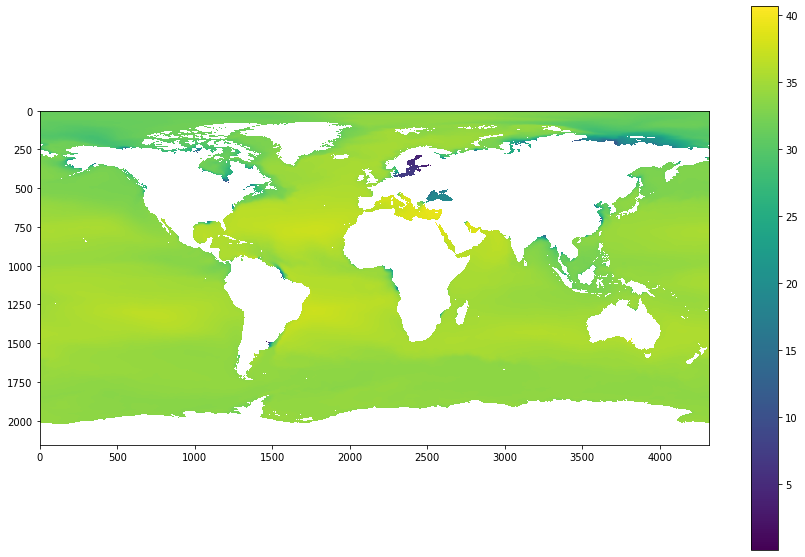

In [309]:
src = rasterio.open('./Data/BO/Present.Surface.Salinity.Mean.tif')
plt.figure(figsize=(15,10))
plt.imshow(src.read(1, masked=True))
plt.colorbar()

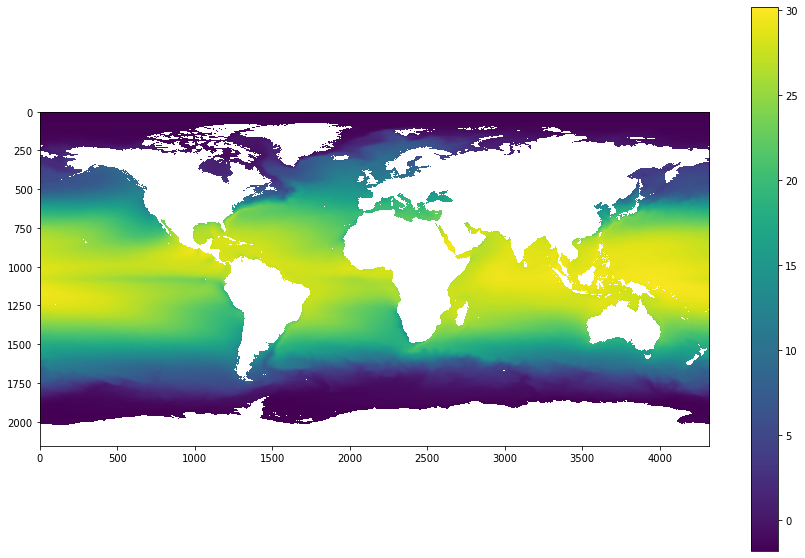

In [310]:
src = rasterio.open('./Data/BO/Present.Surface.Temperature.Mean.tif')
plt.figure(figsize=(15,10))
plt.imshow(src.read(1, masked=True))
plt.colorbar()

<div class="alert alert-info" role="alert">


### European Cropped Raster
    
</div>

In [312]:
from affine import Affine

xmin = -15
xmax = 50
ymin = 30
ymax = 70


def window_from_extent(xmin, xmax, ymin, ymax, aff):
    col_start, row_start = ~aff * (xmin, ymax)
    col_stop, row_stop = ~aff * (xmax, ymin)
    return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))

In [313]:
src = rasterio.open('./Data/BO/Present.Surface.Temperature.Mean.tif')

In [314]:
europe_window = window_from_extent(xmin, xmax, ymin, ymax, src.transform)

In [315]:
europe_view = src.read(1, window=europe_window)

In [316]:
europe_transform = src.window_transform(europe_window)

In [317]:
with rasterio.open('./Data/BO/europe_temp.tif', #filename
                   'w', # file mode, with 'w' standing for "write"
                   driver='GTiff', # format to write the data
                   height=europe_view.shape[0], # height of the image, often the height of the array
                   width=europe_view.shape[1], # width of the image, often the width of the array
                   count=1, # the number of bands to write
                   dtype='float64',# the dtype of the data, usually `ubyte` if data is stored in integers
                   nodata=src.nodata,
                   crs=src.crs, # the coordinate reference system of the data
                   transform=europe_transform # the affine transformation for the image
                  ) as outfile:
    outfile.write(europe_view, indexes=1) # write the `austin_nightlights` as the first band


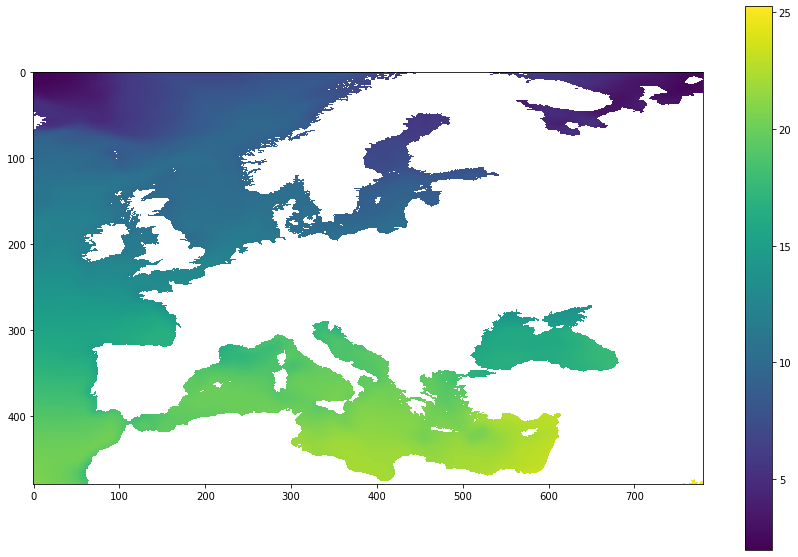

In [326]:
europe = rasterio.open('./Data/BO/europe_temp.tif')
plt.figure(figsize=(15,10))
plt.imshow(europe.read(1, masked=True))
plt.colorbar()

<div class="alert alert-info" role="alert">


### ML model Pipeline
    
</div>

In [319]:
explanatory_rasters = ['./Data/BO/europe_salinity.tif',
                       './Data/BO/europe_temp.tif']
response_data = './Data/output.json'

train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field="obs")

In [320]:
train_xs

array([[17.560742, 14.217478],
       [None, None],
       [None, None],
       ...,
       [5.917129763726138, 8.548724571873949],
       [3.422186, 8.231599],
       [4.892205869296289, 8.531364692546353]], dtype=object)

In [321]:
valid = np.where(np.sum(train_xs == [None, None], axis=1) != 2)[0]

In [322]:
train_xs = train_xs[valid]
train_y = train_y[valid]

In [327]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=1, class_weight="balanced")
clf.fit(train_xs.astype('float32'), train_y.astype('float32'))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [328]:
evaluate_clf(clf, train_xs, train_y)

Accuracy Score: 1.000000

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        69

    accuracy                           1.00       109
   macro avg       1.00      1.00      1.00       109
weighted avg       1.00      1.00      1.00       109


Confussion matrix
[[40  0]
 [ 0 69]]

Feature importances
                   0: 44.7
                   1: 55.3



In [329]:
target_xs, raster_info = load_targets(explanatory_rasters)

In [ ]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [345]:
def plotit(x, title, cmap='Blues'):
    plt.figure(figsize=(15,10))
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [332]:
impute(target_xs, clf, raster_info, outdir='./Data/BO',
        linechunk=1000, class_prob=True, certainty=True)

assert os.path.exists("./Data/BO/responses.tif")
assert os.path.exists("./Data/BO/certainty.tif")
assert os.path.exists("./Data/BO/probability_0.tif")
assert os.path.exists("./Data/BO/probability_1.tif")

In [335]:
res = rasterio.open('./Data/BO/probability_1.tif')

In [336]:
masking = europe.read(1, masked=True).mask

<div class="alert alert-success" role="alert">


### Climatic Suitability Map
    
</div>

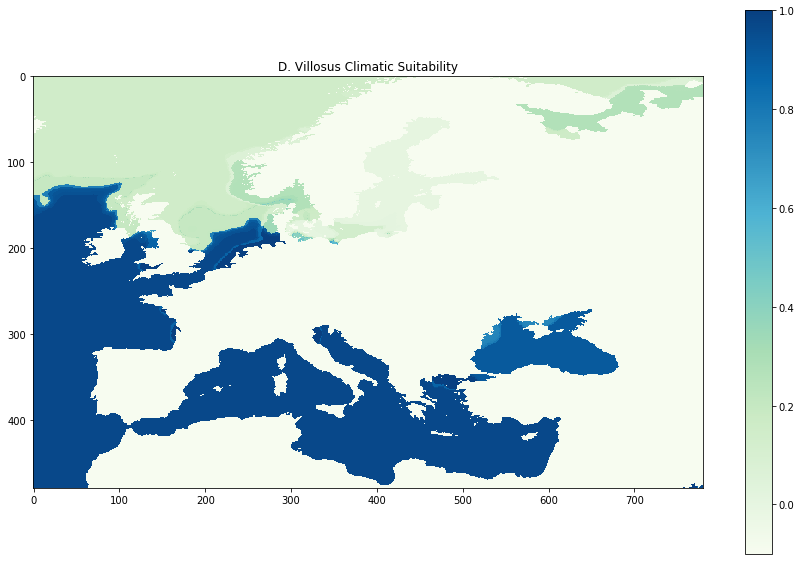

In [346]:
plotit(np.where(masking, -0.1, res.read(1, masked=True)), 'D. Villosus Climatic Suitability', cmap='GnBu')

<div class="alert alert-info" role="alert">


#### Adding features to the model can simply be done by adding more rasters to the input
    
</div>

